epoch 0: [time: 1854.5844554901123 ms]
[D loss: 0.6884532272815704 | acc: 31.25] [G loss: 0.6912164092063904]
real


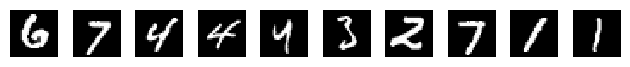

generated


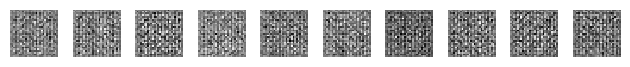

epoch 5: [time: 282.09948539733887 ms]
epoch 10: [time: 265.1784420013428 ms]
epoch 15: [time: 261.7948055267334 ms]
epoch 20: [time: 243.8979148864746 ms]


KeyboardInterrupt: 

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import time
import math

def makeGenerator():
    return Sequential([
        Dense(7 * 7 * 256, input_dim=100),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 256)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="tanh")
    ])

def makeDiscriminator():
    return Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(28, 28, 1)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])

def generate_digits(generator, num=10):
    noise = np.random.normal(0, 1, (num, 100))
    return generator.predict(noise, verbose=0)

def plot(images, cols=10):
    images = np.array(images)
    images = np.squeeze(images)  # Remove single channel dimension if present

    num_images = len(images)

    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols) 
    axes = np.array(axes)
    for i in range(rows * cols):
        ax = axes.flat[i]  # Flatten axes for easy access
        if i < num_images:
            ax.imshow(images[i], cmap="gray", interpolation="nearest")
        ax.axis("off")  # Hide axis ticks

    plt.tight_layout()  # Prevent overlapping
    plt.show()

class GAN:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        gan = Sequential([generator, discriminator])
        gan.compile(loss="binary_crossentropy", 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
        self.gan = gan

    def train(self, X_train, epochs=10000, batch_size=128, latent_dim=100):
        half_batch = batch_size // 2

        for epoch in range(epochs):
            t1 = time.time()

            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            
            fake_imgs = self.generator.predict(noise, verbose=0)

            real_labels = np.ones((half_batch, 1))
            fake_labels = np.zeros((half_batch, 1))

            self.discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            misleading_labels = np.ones((batch_size, 1))

            self.discriminator.trainable = False
            g_loss = self.gan.train_on_batch(noise, misleading_labels)          

            t2 = time.time()

            if epoch % 5 == 0:
                print(f"epoch {epoch}: [time: {(t2-t1) * 1000} ms]")

            # Print progress
            if epoch % 100 == 0:
                print(f"[D loss: {d_loss[0]} | acc: {d_loss[1]*100}] [G loss: {g_loss}]")
                print("real")
                plot(real_imgs[0:10])
                digits = generate_digits(self.generator)
                print(f"generated")
                plot(digits)

if __name__ == '__main__':
    # discriminator model is compiled to allow for training.
    discriminator = makeDiscriminator()
    discriminator.compile(loss="binary_crossentropy", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), metrics=["accuracy"]) 

    # don't compile generator. it is trained as part of the gan.
    generator = makeGenerator()

    (X_train, _), _ = tf.keras.datasets.mnist.load_data()
    X_train = (X_train - 127.5) / 127.5  # Normalize to [-1, 1]
    X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

    gan = GAN(generator, discriminator)
    gan.train(X_train)

